In [57]:
import numpy as np
from matplotlib import pyplot
from IPython.display import display, clear_output

In [59]:
class BernoulliBandit:
    def __init__ (self, means, randomstate = None):
        self.means = means
        self.random = np.random.RandomState(randomstate)
        self.k_star = np.argmax(means)
        self.gaps = means[self.k_star] - means
        self.regret = []
        
    def get_K(self):
        return len(self.means)
    
    def play(self, action):
        self.regret.append(self.gaps[action])
        sample = self.random.rand(self.get_K())
        reward = int(sample[action] < self.means[action])
        return reward
            
    def get_cumulative_regret(self):
        return np.cumsum(self.regret)

In [61]:
def etc(bandit, T, m):
    estimates = []
    for k in range(bandit.get_K()):
        m_estimates = []
        for i in range(m):
            m_estimates.append(bandit.play(k))
        estimates.append(np.mean(m_estimates))

    k_t = np.argmax(estimates)
    for t in range(m * bandit.get_K(), T):
        r_t = bandit.play(k_t)
    return k_t

In [63]:
def etc_experiment(N, T, m, means, seed=None):
    mistakes = 0
    pseudo_regrets = []
    
    for n in range(N):
        bandit = BernoulliBandit(means, seed)
        k_t = etc(bandit, T, m)
        mistakes += (k_t != bandit.k_star)
        pseudo_regrets.append(bandit.get_cumulative_regret())

    avg_cumul_regret = np.mean(pseudo_regrets, axis=0)
    std_cumul_regret = np.std(pseudo_regrets, axis=0)
    
    return  (mistakes / N, avg_cumul_regret, std_cumul_regret)

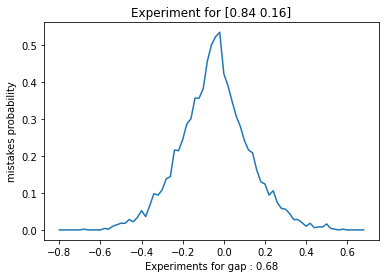

In [76]:
N = 500
m = 10
T = 2 * m + 1

means = np.array([0.1, 0.9])
step = 0.01

cumul_mistakes = []
cumul_gap = []

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(75):
    (mistakes_mean, _, _) = etc_experiment(N, T, m, means)
    cumul_mistakes.append(mistakes_mean)
    
    cumul_gap.append(round(means[0] - means[1], 3));

    x = np.arange(i + 1)
    ax.set_xlim(0, i)
    ax.cla()
    ax.set_title("Experiment for " + str(means))
    ax.set_ylabel('mistakes probability')
    ax.set_xlabel(f'Experiments for gap : {round(means[0] - means[1], 3)}')
    ax.plot(cumul_gap, cumul_mistakes)
    display(fig)
    clear_output(wait = True)
    pyplot.pause(0.1)
    
    means[0] += step
    means[1] -= step
    

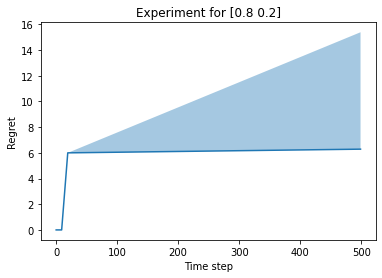

In [20]:
N = 1000
T = 500
m = 10

means = np.array([0.1, 0.9])
step = 0.05

fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(15):
    (_, avg_cumul_regret, std_cumul_regret) = etc_experiment(N, T, m, means)
    cumul_mistakes.append(mistakes_mean)
    
    x = np.arange(len(avg_cumul_regret))
    ax.cla()
    ax.set_title("Experiment for " + str(means))
    ax.set_ylabel('Regret')
    ax.set_xlabel('Time step')
    ax.plot(x, avg_cumul_regret)
    ax.fill_between(x, avg_cumul_regret, avg_cumul_regret + std_cumul_regret, alpha=0.4)
    display(fig)
    clear_output(wait = True)
    pyplot.pause(0.1)
    
    means[0] += step
    means[1] -= step

**a)** L'algorithme ETC (explore then commit) n'est pas uniformément efficace, c'est à dire qu'il va souffrir de regret linéaire pour les instances plus difficile comme on peut le voir sur la figure 2 et va avoir tendance à converger vers des actions sous-optimal due à leurs exploration limité.

Pour appuyer cela, nous avons réaliser plusieurs experience avec à chaque fois des instances de bandits avec un gap plus ou moins grand et nous avons enregistrer à chaque fois la probabilité de choisir la mauvaise action. A chaque experience, le gap des moyennes de notre bandit vont se rapprocher, on peut voir en temps réel sur la première figure la probabilité de choisir la mauvaise action, sur la deuxieme on peut voir le regret devenant linéaire quand les performance ne sont pas bonne.

- 

In [4]:
class NormalBandit:
    def __init__ (self, means, sigma, randomstate = None):
        self.sigma = sigma
        self.means = means
        self.random = np.random.RandomState(randomstate)
        self.k_star = np.argmax(means)
        self.gaps = means[self.k_star] - means
        self.regret = []
        
    def get_K(self):
        return len(self.means)
    
    def play(self, action):
        self.regret.append(self.gaps[action])
        return self.random.normal(self.means[action], self.sigma[action])
            
    def get_cumulative_regret(self):
        return np.cumsum(self.regret)

In [5]:
def egreedy(bandit, T, eps, init_estimator=lambda K: np.zeros(K), seed=None):
    random = np.random.RandomState(seed)
    K = bandit.get_K()
    avgs = init_estimator(K)
    plays = np.zeros(K)
    for t in range(T):
        if random.rand() < eps:
            k_t = random.choice(K)
        else:
            k_t = np.argmax(avgs)
        r_t = bandit.play(k_t)
        avgs[k_t] = (plays[k_t] * avgs[k_t] + r_t) / (plays[k_t] + 1)
        plays[k_t] += 1

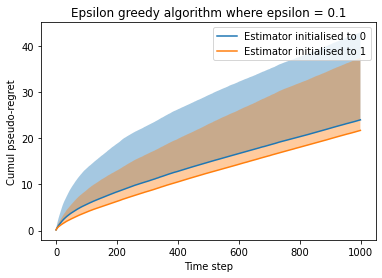

In [40]:
T = 1000
N = 500
K = 2

random = np.random.RandomState(67)

means_instance = random.rand(N, K)
sigma_instance = random.rand(N, K)

pseudo_regrets = {'zero_init': [], 'one_init': []}

for n in range(N):
    banditA = NormalBandit(means_instance[n], sigma_instance[n], randomstate=n)
    egreedy(banditA, T, 0.1, seed=n)
    pseudo_regrets["zero_init"].append(banditA.get_cumulative_regret())
    
    banditB = NormalBandit(means_instance[n], sigma_instance[n], randomstate=n)
    egreedy(banditB, T, 0.1, init_estimator=lambda K: np.full(K, 1.0), seed=n)
    pseudo_regrets["one_init"].append(banditB.get_cumulative_regret())
    

avg_cumul_regret = {
    'zero_init': np.mean(pseudo_regrets['zero_init'], axis=0), 
    'one_init': np.mean(pseudo_regrets['one_init'], axis=0)}
std_cumul_regret = {
    'zero_init': np.std(pseudo_regrets['zero_init'], axis=0), 
    'one_init': np.std(pseudo_regrets['one_init'], axis=0)}

pyplot.plot(avg_cumul_regret["zero_init"], label="Estimator initialised to 0")
pyplot.fill_between(np.arange(T), 
                    avg_cumul_regret["zero_init"], 
                    avg_cumul_regret["zero_init"] + std_cumul_regret["zero_init"], alpha=0.4)

pyplot.plot(avg_cumul_regret["one_init"], label="Estimator initialised to 1")
pyplot.fill_between(np.arange(T), 
                    avg_cumul_regret["one_init"], 
                    avg_cumul_regret["one_init"] + std_cumul_regret["one_init"], alpha=0.4)

pyplot.xlabel("Time step")
pyplot.ylabel("Cumul pseudo-regret")
pyplot.title("Epsilon greedy algorithm where epsilon = 0.1")
pyplot.legend()

**b)** Pour rendre l'algorithme espilon-greedy optimiste, nous avons procéder à une experience comparative sur des bandits à distribution normal.

Dans un premier temps, nous avons généré N instances de two armed bandits.
Pour cette même instance nous avons minimiser le regret grace l'algorithme epsilon-greedy :
Pour l'experience 1, nous avons initialisé les estimateurs empirique à 0 et pour l'experience 2, nous les avons initialisé à 1.
Nous avons ensuite afficher les pseudo regret cumulatif de ses 50 instances dans un graphique.

- Pour que l'effet soit bien perseptible et non biaiser par l'aléatoire, il est important de prendre un grand nombre d'instances de bandits

Nous pouvons constater à première vu que le pseudo regret cumulatif moyen de l'experience 2 est généralement lègerement plus petit.
Le choix d'initialiser les estimateurs empirique à 1 est d'encourager l'exploration ...